In [1]:
from pathlib import Path

import h5py

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms

from nnunet.training.model_restore import restore_model

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/bruno-pacheco/brats-generalization')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

In [3]:
model_dir = PROJ_ROOT/'models/nnUNet/2d/Task109_BraTS2020_T1only/nnUNetTrainerV2BraTSRegions_BN_Our__nnUNetPlansv2.1/all'

# contains info about the trainer (aux functions)
model_pkl = model_dir/'model_final_checkpoint.model.pkl'

# model data
model_checkpoint = model_dir/'model_final_checkpoint.model'

trainer = restore_model(model_pkl, checkpoint=model_checkpoint, train=False)

trainer.deterministic

220420-15:45:41,161 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.6.0
2022-04-20 15:45:41.176793: self.max_num_epochs: 50
2022-04-20 15:45:41.177026: loading checkpoint /home/bruno-pacheco/brats-generalization/models/nnUNet/2d/Task109_BraTS2020_T1only/nnUNetTrainerV2BraTSRegions_BN_Our__nnUNetPlansv2.1/all/model_final_checkpoint.model train= False


False

In [5]:
class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

model = BraTSnnUNet(trainer.network)
model.cpu()

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [18]:
PROJ_ROOT

PosixPath('/home/bruno-pacheco/brats-generalization')

In [7]:
torch.save(model, PROJ_ROOT/'models/brats_model.pt')

In [2]:
class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

#         label = torch.Tensor([label])
#         label = label.view(label.shape[0], 1)

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

ds = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', dataset='train')
ds

In [3]:
from torch.utils.data import DataLoader

loader = DataLoader(ds, batch_size=2)

In [4]:
X, y = next(iter(loader))
print(X.shape)
print(y.shape)

torch.Size([2, 1, 192, 160])
torch.Size([2])


In [12]:
y_pred = model(X)
y_pred

tensor([0.3717, 0.3624], grad_fn=<SqueezeBackward0>)

In [13]:
y

tensor([76, 76], dtype=torch.uint8)

In [17]:
(y_pred - y).abs().mean().item()

75.63298034667969

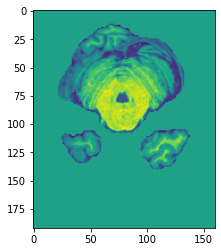

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(X[0,0].detach().numpy())
plt.show()

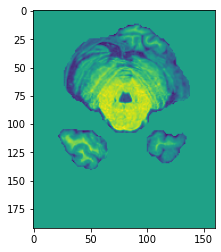

In [19]:
from torchvision import transforms



plt.imshow(transforms.functional.hflip(X)[0,0].detach().numpy())
plt.show()